## <a name="C4"> Projet 5 : Segmentez les clients d'un site de e-commerce</a>
## <a name="C4"> 2 : Essai de modélisation</a>

La segmentation RFM (Récence, Fréquence, Valeur Monétaire) est une technique de marketing qui analyse et classe les clients en fonction de trois dimensions : la récence, ou le temps écoulé depuis la dernière interaction ou achat du client ; la fréquence, soit le nombre d'interactions ou d'achats effectués par le client sur une période donnée ; et la valeur monétaire, c'est-à-dire le montant total dépensé par le client. Comparer la segmentation RFM avec la segmentation K-means est particulièrement utile car ces deux approches sont complémentaires. La segmentation RFM se base sur des critères spécifiques et prédéfinis, tandis que la segmentation K-means permet de trouver des patterns naturels dans les données sans hypothèses initiales. Cette comparaison aide à valider les segments identifiés par chaque méthode, assurant ainsi une segmentation plus robuste et fiable. En combinant les insights des deux méthodes, les entreprises peuvent optimiser leurs stratégies marketing, mieux cibler leurs efforts et améliorer la satisfaction et la fidélisation de leurs clients.

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import squarify
from math import pi
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import euclidean
from itertools import combinations
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("Librairies importées avec succès !")

Librairies importées avec succès !


In [3]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.0.3
NumPy: 1.24.3
Matplotlib: 3.7.2
Seaborn: 0.12.2


- Création des fonctions utiles

In [4]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


In [5]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(25, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


- Lecture des fichiers de données

In [6]:
data = pd.read_csv('data.csv', sep = ";")
rfm = pd.read_csv('rfm.csv', sep = ";")
features = pd.read_csv('features.csv', sep = ";")
print("Fichier importé avec succès !")

Fichier importé avec succès !


In [7]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,3149.0,-23.576983,-46.587161,8
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,3366.0,-23.564630,-46.534268,2
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,2290.0,-23.600462,-46.655318,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112905,0b82d0616f1ad8da15cf967b984b4004,986632b40c38f4240caf8608cb01d40d,delivered,2018-08-03 21:35:53,2018-08-08 14:26:00,2018-08-09 21:42:08,2018-08-10,1,4a24717893a6c8f3cfcf9843b8987d15,2cb6eb1b7185064167657fa09f541105,...,1,boleto,1,33.69,dbcc8337677aaefa8a711819880d4cf9,5,30575.0,-19.973801,-43.972640,6
112906,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06,1,9c313adb4b38a55b092f53f83f78be9e,ef728fa1f17436c91ed1ccd03dcf9631,...,1,credit_card,1,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,9951.0,-23.689006,-46.590933,3
112907,2ef4a11b6e24fdfbb43b92cb5f95edff,ee1cfdc92e449920e25d3ca4ab4da4f6,delivered,2018-07-23 18:35:14,2018-07-24 14:37:00,2018-07-27 14:04:10,2018-08-06,2,eacb104882d39ffb53140b1d1860a7c3,ef728fa1f17436c91ed1ccd03dcf9631,...,1,credit_card,1,84.63,ad0de1dda4fa03e8efb68c481b31ebf8,3,9951.0,-23.689006,-46.590933,3
112908,2c4ada2e75c2ad41dd93cebb5df5f023,363d3a9b2ec5c5426608688ca033292d,delivered,2017-01-26 11:09:00,2017-01-27 14:59:35,2017-02-14 16:24:01,2017-03-07,1,6c7a0a349ad11817745e3ad58abd5c79,48162d548f5b1b11b9d29d1e01f75a61,...,1,credit_card,1,209.06,82ec4a1c6f0134f607033e23431ee298,4,76940.0,-11.722454,-61.777036,19


In [8]:
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69


In [9]:
features

,customer_unique_id,total_items,average_installments,freight,average_delivery_delay,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,8.0,0.08,6.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,0.30,3.0,4.0
2,0000f46a3911fa3c0805444483337064,1,8.0,0.20,25.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,4.0,0.40,20.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,6.0,0.09,13.0,5.0
...,...,...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,2,10.0,0.12,27.0,5.0
91225,fffea47cd6d3cc0a88bd621562a9d061,1,1.0,0.23,30.0,4.0
91226,ffff371b4d645b6ecea244b27531430a,1,1.0,0.20,14.0,5.0
91227,ffff5962728ec6157033ef9805bacc48,1,5.0,0.14,11.0,5.0


## <a name="C4"> Segmentation via score RFM</a>

- Calcul des scores 

In [10]:
rfm["recency_score"]  = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"]= pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['rfm_score'] = rfm.recency_score.astype(str)+ rfm.frequency_score.astype(str) + rfm.monetary_score.astype(str)

rfm.head()

,customer_unique_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214


- Segmentation

![segmentationeng.png](attachment:segmentationeng.png)
Source : https://documentation.bloomreach.com/engagement/docs/rfm-segmentation

In [11]:
rfm_segmentation = {
    'Lost customers': ['111', '112', '121', '131', '141', '151'],
    'Hibernating customers': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
    'About To Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Potential Loyalist': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
    'Loyal': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Champions': ['555', '554', '544', '545', '454', '455', '445']
}

In [12]:
def get_customer_segment(rfm_score):
    for segment, scores in rfm_segmentation.items():
        if rfm_score in scores:
            return segment
    return 'Unknown'

rfm['segment'] = rfm['rfm_score'].apply(get_customer_segment)

rfm.head()

,customer_unique_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them


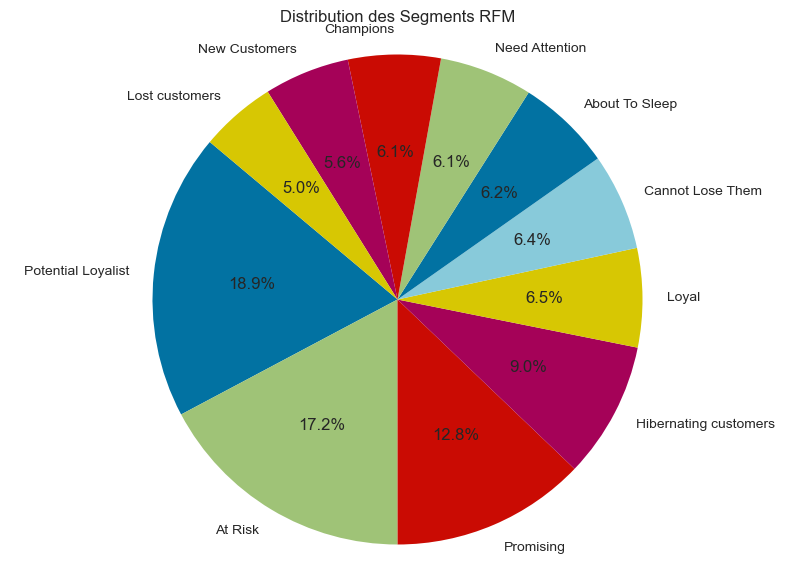

In [13]:
segment_counts = rfm['segment'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Segments RFM')
plt.axis('equal')  
plt.show()


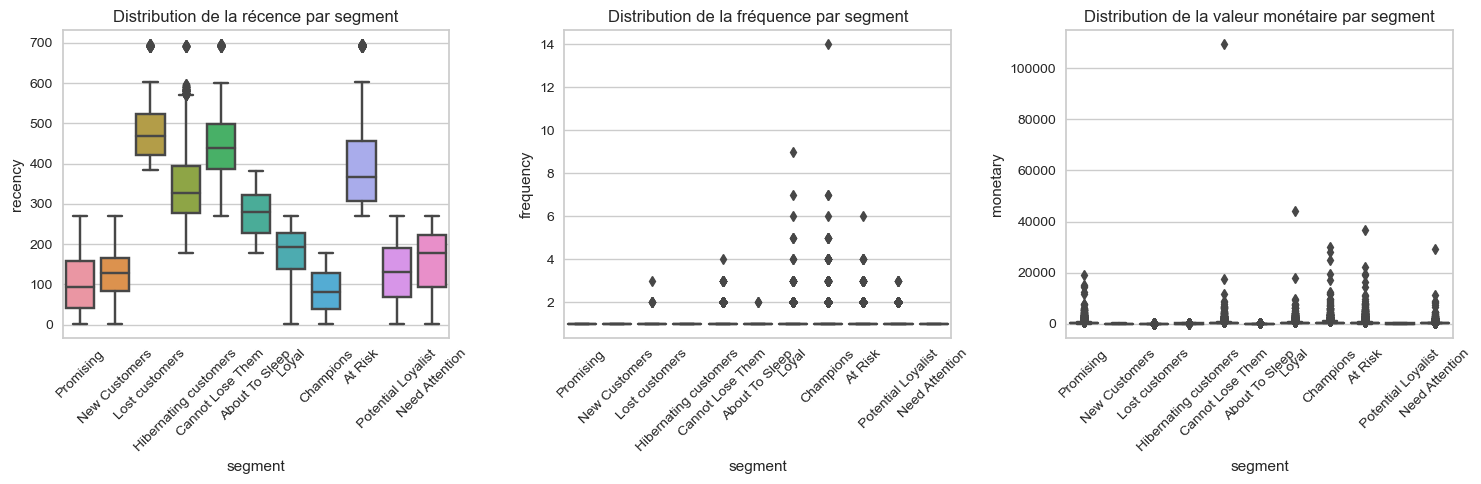

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm, x='segment', y='recency')
plt.title('Distribution de la récence par segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm, x='segment', y='frequency')
plt.title('Distribution de la fréquence par segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm, x='segment', y='monetary')
plt.title('Distribution de la valeur monétaire par segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## <a name="C4"> Preparation des données</a>

- Observation des données

In [15]:
rfm_df = rfm.drop(["recency_score", "frequency_score", "monetary_score", "rfm_score", "segment"], axis=1)
rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69


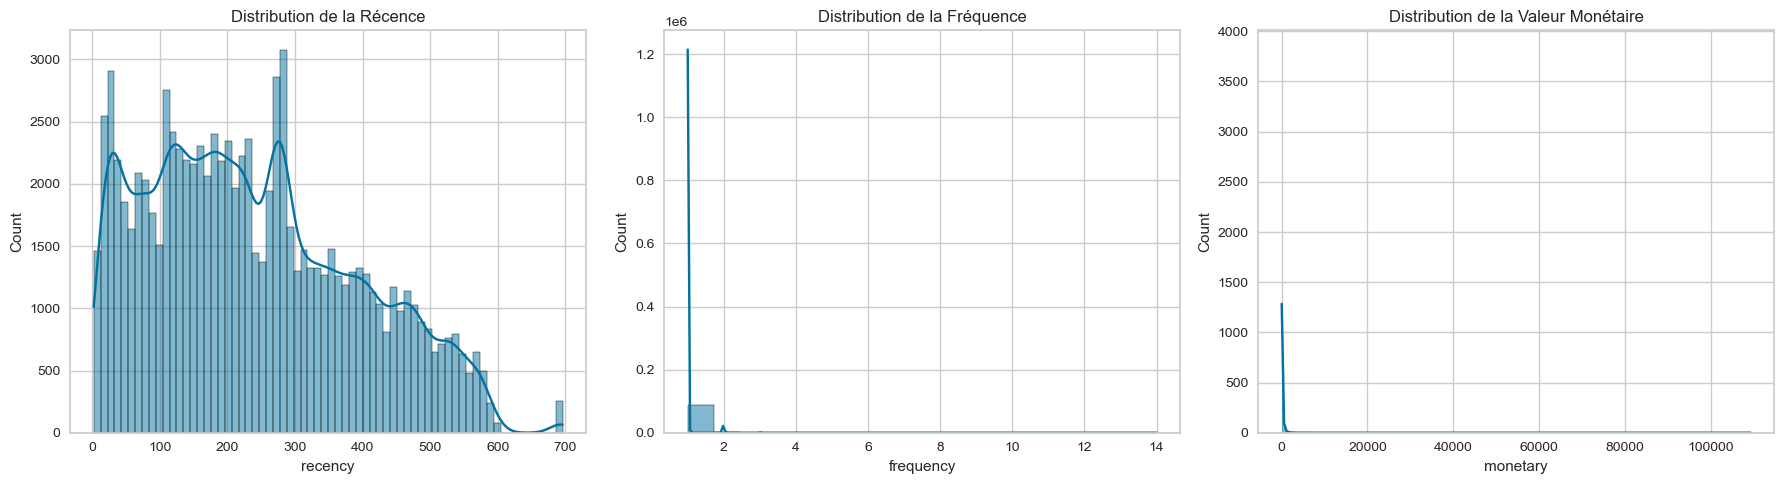

In [16]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['recency'], kde=True)
plt.title('Distribution de la Récence')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['frequency'], kde=True)
plt.title('Distribution de la Fréquence')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['monetary'], kde=True)
plt.title('Distribution de la Valeur Monétaire')

plt.tight_layout()
plt.show()


- Transformation des données

In [17]:
rfm_log = rfm_df.copy()
for i in rfm_log.columns[1:]:
    rfm_log[i] = np.log10(rfm_log[i])
rfm_log.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2.053078,0.0,2.151982
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.064458,0.0,1.434409
2,0000f46a3911fa3c0805444483337064,2.730782,0.0,1.935608
3,0000f6ccb0745a6a4b88665a16c9f078,2.507856,0.0,1.639686
4,0004aac84e0df4da2b147fca70cf8255,2.460898,0.0,2.294224


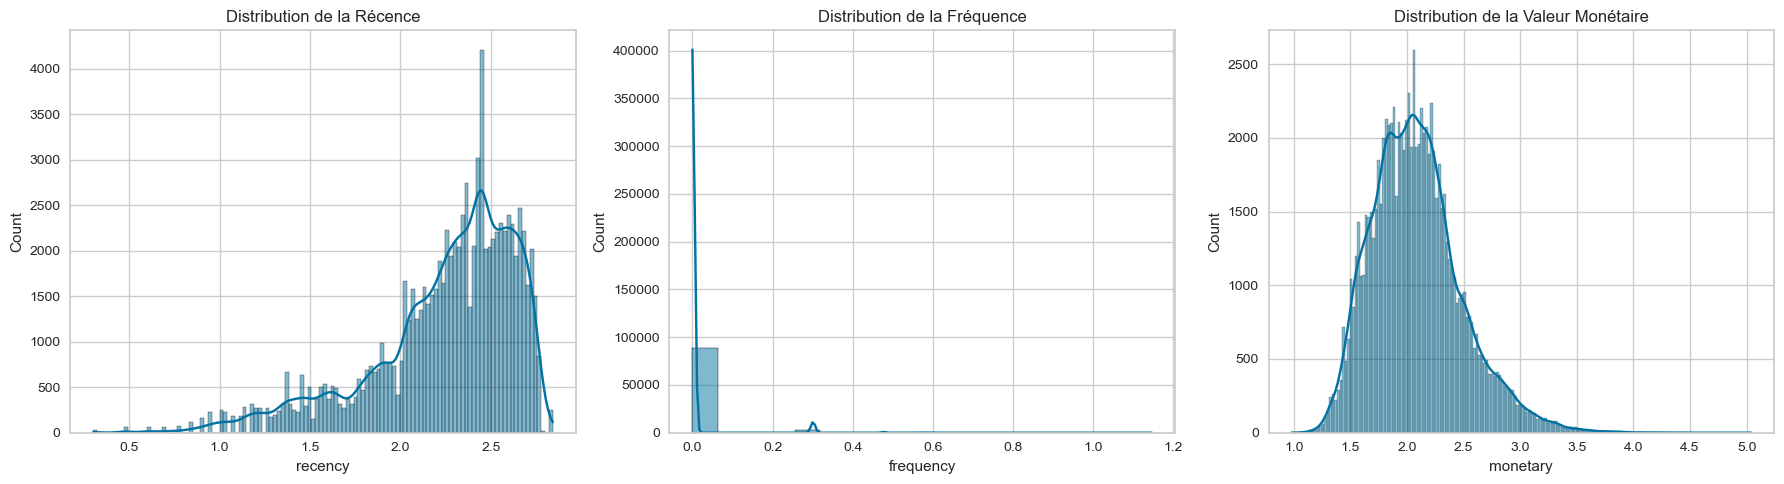

In [18]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_log['recency'], kde=True)
plt.title('Distribution de la Récence')

plt.subplot(1, 3, 2)
sns.histplot(rfm_log['frequency'], kde=True)
plt.title('Distribution de la Fréquence')

plt.subplot(1, 3, 3)
sns.histplot(rfm_log['monetary'], kde=True)
plt.title('Distribution de la Valeur Monétaire')

plt.tight_layout()
plt.show()


- Standardisation des données

In [19]:
columns_to_scale = rfm_log.columns[1:]
rfm_log_to_scale = rfm_log[columns_to_scale]

# Standardisation des colonnes sélectionnées
standardscaler = StandardScaler()
rfm_log_scaled = standardscaler.fit_transform(rfm_log_to_scale)
rfm_log_scaled_df = pd.DataFrame(rfm_log_scaled, columns=columns_to_scale)

rfm_log_scaled_df.head()


,recency,frequency,monetary
0,-0.463701,-0.171006,0.167449
1,-0.435693,-0.171006,-1.635981
2,1.204339,-0.171006,-0.376351
3,0.655648,-0.171006,-1.120073
4,0.540069,-0.171006,0.524934


## <a name="C4"> K-means</a>

- Détérmination du nombre de clusters

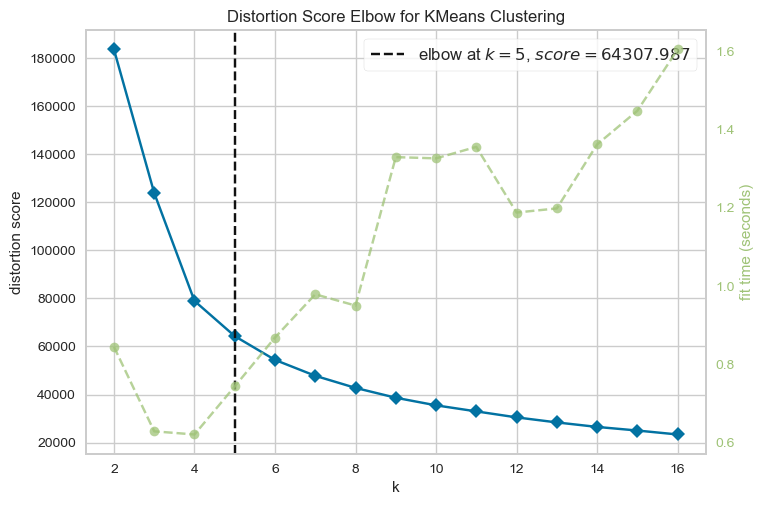

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
kmeans_model = KMeans()
elbow = KElbowVisualizer(kmeans_model, k=(2,17))

elbow.fit(rfm_log_scaled_df) 
elbow.poof() 

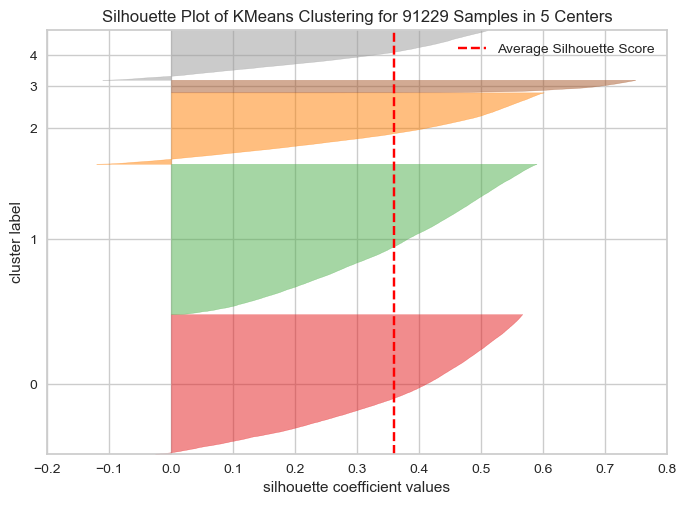

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 91229 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(rfm_log_scaled_df) 
visualizer.poof()

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_log_scaled_df)

KMeans(n_clusters=5)

- Evaluation du modèle

In [23]:
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans

y_kmeans = kmeans.labels_

inertia = kmeans.inertia_
print(f"Inertie (WCSS): {inertia}")

dbi = davies_bouldin_score(rfm_log_scaled_df, y_kmeans)
print(f"Indice de Davies-Bouldin: {dbi}")

silhouette_avg = silhouette_score(rfm_log_scaled_df, y_kmeans)
print(f"Indice de Silhouette: {silhouette_avg}")

Inertie (WCSS): 64304.6509880042
Indice de Davies-Bouldin: 0.809820698377484
Indice de Silhouette: 0.3596131902271296


- Une inertie élevée indique que les points sont globalement éloignés des centres de leurs clusters respectifs, suggérant des clusters moins compacts.

- Un indice de Davies-Bouldin proche de 0 indique que les clusters sont bien séparés et compacts. Un score de 0.75 suggère une bonne séparation et compacité relative des clusters.

- Un indice de Silhouette de 0.40 indique une qualité de clustering modérée. Les points sont relativement bien regroupés dans leurs clusters, mais la séparation entre les clusters pourrait être améliorée.

- Analyse des clusters

In [24]:
rfm_log_scaled_df['cluster']= kmeans.labels_
rfm_log_scaled_df.head()

,recency,frequency,monetary,cluster
0,-0.463701,-0.171006,0.167449,1
1,-0.435693,-0.171006,-1.635981,0
2,1.204339,-0.171006,-0.376351,0
3,0.655648,-0.171006,-1.120073,0
4,0.540069,-0.171006,0.524934,1


In [25]:
rfm_km_df = rfm_df.copy()
rfm_km_df['cluster'] = kmeans.labels_
rfm_km_df

,customer_unique_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,0
2,0000f46a3911fa3c0805444483337064,538,1,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,1
...,...,...,...,...,...
91224,fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84,3
91225,fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,0
91226,ffff371b4d645b6ecea244b27531430a,569,1,112.46,1
91227,ffff5962728ec6157033ef9805bacc48,120,1,133.69,1


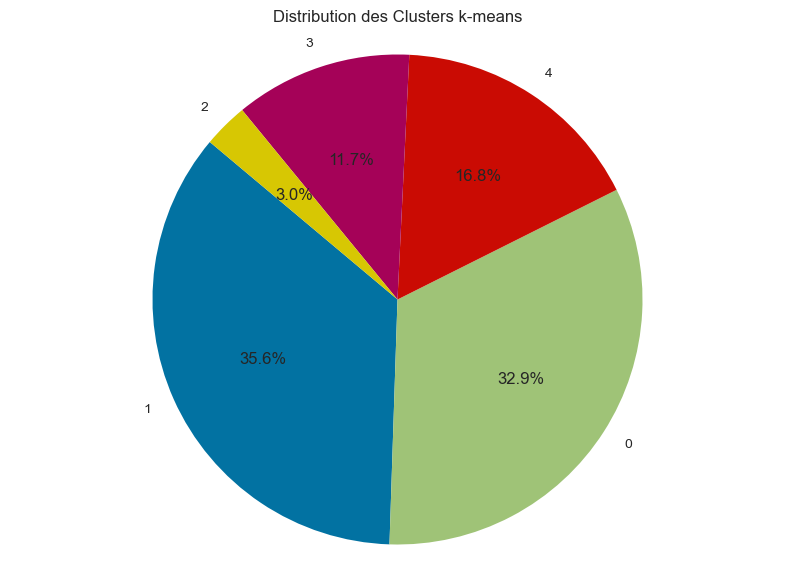

In [26]:
segment_counts = rfm_km_df['cluster'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Clusters k-means')
plt.axis('equal')  
plt.show()


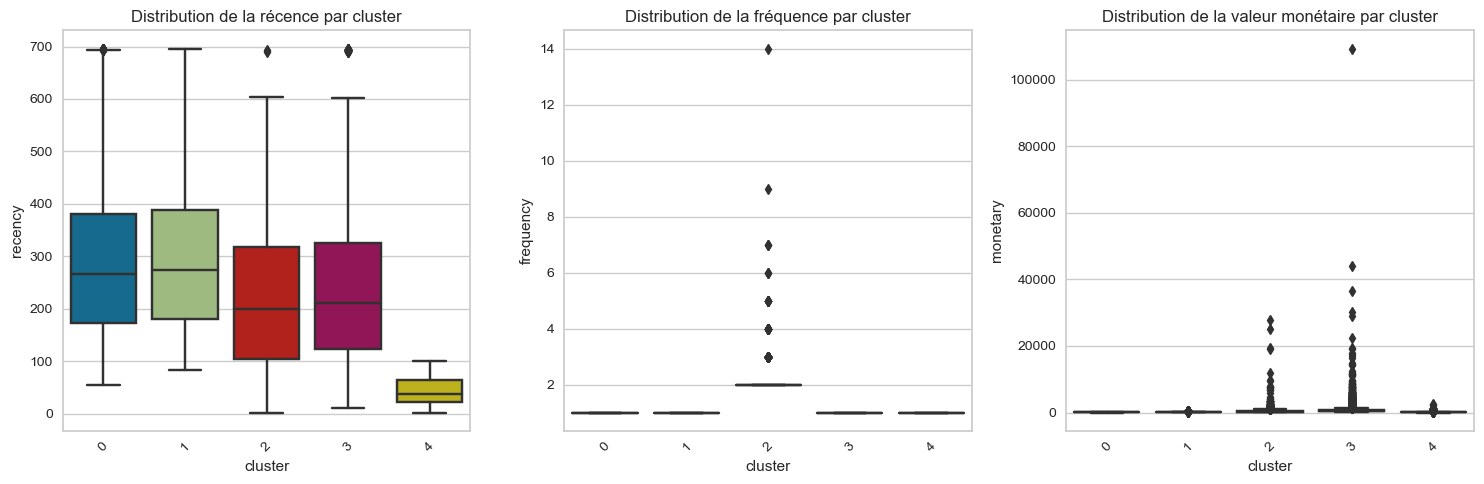

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm_km_df, x='cluster', y='recency')
plt.title('Distribution de la récence par cluster')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm_km_df, x='cluster', y='frequency')
plt.title('Distribution de la fréquence par cluster')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm_km_df, x='cluster', y='monetary')
plt.title('Distribution de la valeur monétaire par cluster')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Comparaison entre clusters K-means et segments RFM

Scores des métriques d'évaluation:
                              Metric     Score
0          Adjusted Rand Index (ARI)  0.108183
1  Adjusted Mutual Information (AMI)  0.262397


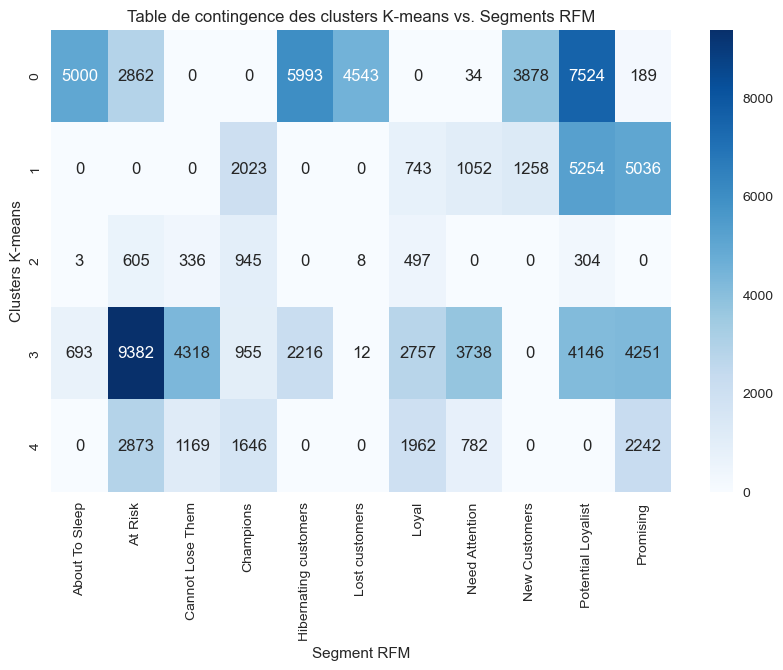

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

rfm_segment = rfm['segment']
kmeans_clusters = kmeans.fit_predict(rfm_log_scaled_df)

comparison_df = pd.DataFrame({
    'kmeans_clusters': kmeans_clusters,
    'rfm_segment': rfm_segment
})

contingency_table = pd.crosstab(comparison_df['kmeans_clusters'], comparison_df['rfm_segment'])

ari_score = adjusted_rand_score(comparison_df['rfm_segment'], comparison_df['kmeans_clusters'])
ami_score = adjusted_mutual_info_score(comparison_df['rfm_segment'], comparison_df['kmeans_clusters'])

# Créer un DataFrame pour les scores des métriques d'évaluation
evaluation_scores = pd.DataFrame({
    'Metric': ['Adjusted Rand Index (ARI)', 'Adjusted Mutual Information (AMI)'],
    'Score': [ari_score, ami_score]
})

print("Scores des métriques d'évaluation:")
print(evaluation_scores)

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Table de contingence des clusters K-means vs. Segments RFM')
plt.xlabel('Segment RFM')
plt.ylabel('Clusters K-means')
plt.show()

Cluster K-means 0 : Loyal  
Cluster K-means 1 : At Risk  
Cluster K-means 2 : Lost Customers  
Cluster K-means 3 : Need Attention      
Cluster K-means 4 : Champions  

In [29]:
clusters_name = {
    0: 'Loyal',
    1: 'At Risk',
    2: 'Lost Customers',
    3: 'Need Attention',
    4: 'Champions'}

rfm_km_df['cluster'] = rfm_km_df['cluster'].replace(clusters_name)
rfm_km_df.head()

,customer_unique_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,At Risk
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,Loyal
2,0000f46a3911fa3c0805444483337064,538,1,86.22,Loyal
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,Loyal
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,At Risk


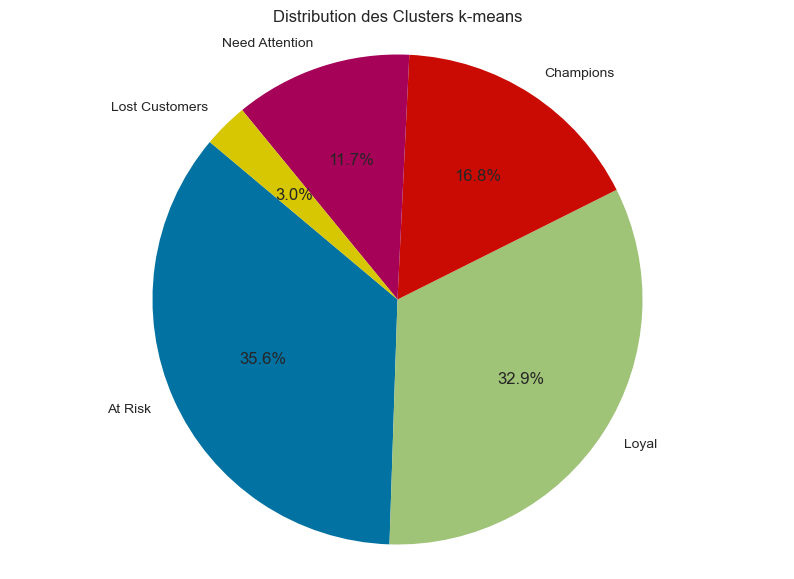

In [30]:
segment_counts = rfm_km_df['cluster'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution des Clusters k-means')
plt.axis('equal')  
plt.show()


In [32]:
rfm.to_csv('./rfm_2.csv', index=False, sep=';', encoding='utf-8')